In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_dataset = '/content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11'

In [4]:
# Проверка структуры dataset
import os

def print_dataset_tree(root_dir):
    print("Структура датасета:\n")
    print(f"{os.path.basename(root_dir)}/")

    for split in ['train', 'valid', 'test']:
        split_path = os.path.join(root_dir, split)
        if os.path.isdir(split_path):
            print(f"├── {split}/")
            for sub in ['images', 'labels']:
                sub_path = os.path.join(split_path, sub)
                if os.path.isdir(sub_path):
                    print(f"│   ├── {sub}/")
                else:
                    print(f"│   ├──  {sub}/ (нет папки)")
        else:
            print(f"├──  {split}/ (нет папки)")

    yaml_path = os.path.join(root_dir, 'data.yaml')
    if os.path.isfile(yaml_path):
        print("├── data.yaml")
    else:
        print("├──  data.yaml не найден")



In [5]:
print_dataset_tree(path_dataset)

Структура датасета:

My_First_Project.v4i.yolov11/
├── train/
│   ├── images/
│   ├── labels/
├── valid/
│   ├── images/
│   ├── labels/
├── test/
│   ├── images/
│   ├── labels/
├── data.yaml


# Импорт

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [7]:
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import torch
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# class YOLO_Trainer

In [8]:
class YOLO_Trainer:
    def __init__(self,
                 data_yaml: str,
                 model_name: str = 'yolov8n.pt',
                 epochs: int = 20,
                 batch: int = 16,
                 imgsz: int = 640,
                 lr0: float = 0.01,
                 weight_decay: float = 0.0005,
                 project: str = 'runs',
                 name: str = 'exp',
                 **kwargs):
        self.data_yaml = data_yaml
        self.model_name = model_name
        self.epochs = epochs
        self.batch = batch
        self.imgsz = imgsz
        self.lr0 = lr0
        self.weight_decay = weight_decay
        self.project = project
        self.name = name
        self.extra_args = kwargs
        self.model = YOLO(model_name)

    def setup_model(self):
        print(f"[INFO] Model {self.model_name} loaded.")

    def train(self):
        print(f"[INFO] Starting training for {self.epochs} epochs, batch size {self.batch}, img size {self.imgsz}...")
        self.model.train(
            data=self.data_yaml,
            epochs=self.epochs,
            batch=self.batch,
            imgsz=self.imgsz,
            lr0=self.lr0,
            weight_decay=self.weight_decay,
            project=self.project,
            name=self.name,
            **self.extra_args
        )
        print(f"[INFO] Training finished. Results saved in '{self.project}/{self.name}'")

    def evaluate(self, split='val'):
        print(f"[INFO] Evaluating on {split} set...")
        results = self.model.val(data=self.data_yaml, split=split)
        return results

    def plot_metrics(self):
        """
        Показывает график обучения (loss, precision, recall, mAP).
        """
        print("[INFO] Plotting training metrics...")
        metrics_path = os.path.join(self.project, self.name, 'results.png')
        if os.path.exists(metrics_path):
            from IPython.display import Image, display
            display(Image(filename=metrics_path))
        else:
            print("[WARN] Metrics image not found. Проверь, завершилось ли обучение.")

    def plot_metrics_interactive(self):
        # Путь к CSV-файлу
        csv_path = os.path.join(self.project, self.name, 'results.csv')
        if not os.path.exists(csv_path):
            print(f"[ERROR] CSV file not found at: {csv_path}")
            return

        df = pd.read_csv(csv_path)

        # Создаем фигуру с 2 рядами и 2 колонками
        fig = sp.make_subplots(rows=2, cols=2,
                               subplot_titles=("Box Loss", "Cls Loss", "Precision & Recall", "mAP"))

        # 1) Box Loss (train и val)
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['train/box_loss'],
                                 mode='lines+markers', name='train/box_loss'), row=1, col=1)
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['val/box_loss'],
                                 mode='lines+markers', name='val/box_loss'), row=1, col=1)

        # 2) Classification Loss (train и val)
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['train/cls_loss'],
                                 mode='lines+markers', name='train/cls_loss'), row=1, col=2)
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['val/cls_loss'],
                                 mode='lines+markers', name='val/cls_loss'), row=1, col=2)

        # 3) Precision & Recall
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['metrics/precision(B)'],
                                 mode='lines+markers', name='Precision'), row=2, col=1)
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['metrics/recall(B)'],
                                 mode='lines+markers', name='Recall'), row=2, col=1)

        # 4) mAP@0.5 и mAP@0.5:0.95
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['metrics/mAP50(B)'],
                                 mode='lines+markers', name='mAP50'), row=2, col=2)
        fig.add_trace(go.Scatter(x=df['epoch'], y=df['metrics/mAP50-95(B)'],
                                 mode='lines+markers', name='mAP50-95'), row=2, col=2)

        fig.update_layout(height=900, width=1200, title_text="YOLOv8 Training Metrics")
        fig.show()

    def predict_and_confusion_matrix(self, image_dir, true_labels):
        """
        Прогоняет все изображения из папки через модель и строит confusion matrix.
        :param image_dir: путь к папке с изображениями
        :param true_labels: список true-классов в том же порядке, что и файлы
        """
        print("[INFO] Predicting and building confusion matrix...")
        preds = []

        image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))])
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(image_dir, image_file)
            results = self.model.predict(source=image_path, save=False, verbose=False)
            pred_classes = [int(x.cls) for x in results[0].boxes] if results and results[0].boxes else [None]
            # берем первый предсказанный класс (если их несколько, можешь доработать)
            preds.append(pred_classes[0] if pred_classes else None)

        cm = confusion_matrix(true_labels, preds, labels=sorted(set(true_labels)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

In [9]:
# Пути к файлам
data_yaml_path = path_dataset + '/data.yaml'

# Запуск YOLO8

    data_yaml = data_yaml_path,
    model_name = 'yolov8n.pt',
    epochs = 40,
    batch = 16,
    imgsz = 640,
    lr0 = 0.01,
    weight_decay = 0.0005,
    project = project_dir,
    name = 'exp1',
    # Дополнительные параметры аугментации и настройки обучения:
    label_smoothing = 0.1,
    mosaic = 0.15,
    mixup = 0.3,
    iou = 0.4,
    patience = 6

In [11]:
# Папка для сохранения результатов
project_dir = '/content/drive/MyDrive/Zebra/Results'

In [ ]:
trainer = YOLO_Trainer(
    data_yaml = data_yaml_path,
    model_name = 'yolov8n.pt',
    epochs = 40,
    batch = 16,
    imgsz = 640,
    lr0 = 0.01,
    weight_decay = 0.0005,
    project = project_dir,
    name = 'exp1',
    # Дополнительные параметры аугментации и настройки обучения:
    label_smoothing = 0.1,
    mosaic = 0.15,
    mixup = 0.3,
    iou = 0.4,
    patience = 6
)

In [ ]:
trainer.setup_model()
trainer.train()
metrics = trainer.evaluate()

[INFO] Model yolov8n.pt loaded.
[INFO] Starting training for 40 epochs, batch size 16, img size 640...
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.4, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.3, mode=train, 

100%|██████████| 755k/755k [00:00<00:00, 76.4MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 283MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.1±0.0 MB/s, size: 70.1 KB)


train: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/train/labels.cache... 822 images, 471 backgrounds, 0 corrupt: 100%|██████████| 822/822 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 0.1±0.0 MB/s, size: 73.9 KB)


val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/valid/labels.cache... 78 images, 43 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Zebra/Results/exp1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Zebra/Results/exp1
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.02G      1.627      3.348      1.502         13        640: 100%|██████████| 52/52 [00:22<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.37s/it]

                   all         78        212     0.0065      0.567      0.323      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       2.5G      1.332      2.375      1.251         17        640: 100%|██████████| 52/52 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         78        212      0.738      0.265      0.437      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.51G      1.266      2.074      1.202         31        640: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         78        212      0.599      0.538      0.574      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.51G      1.226      1.963       1.19         35        640: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         78        212      0.444      0.596       0.55      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.51G      1.134      1.788       1.15         27        640: 100%|██████████| 52/52 [00:20<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         78        212      0.399       0.79      0.538      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.51G      1.104      1.711      1.133         15        640: 100%|██████████| 52/52 [00:18<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         78        212       0.54      0.694       0.61      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.51G      1.063      1.617       1.09         19        640: 100%|██████████| 52/52 [00:20<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         78        212      0.559      0.728      0.597      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.52G      1.072      1.552      1.103          4        640: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         78        212      0.514      0.666      0.618      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.53G      1.013       1.53      1.099         18        640: 100%|██████████| 52/52 [00:18<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         78        212      0.466      0.855      0.604      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.53G     0.9815       1.41      1.065         15        640: 100%|██████████| 52/52 [00:17<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         78        212      0.466      0.746      0.595      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.54G     0.9482      1.397      1.061         37        640: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         78        212      0.573      0.702      0.598      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.55G     0.9837      1.444      1.087         22        640: 100%|██████████| 52/52 [00:19<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         78        212      0.523      0.762      0.609      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.56G     0.9444      1.383      1.074         18        640: 100%|██████████| 52/52 [00:18<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         78        212      0.549      0.734      0.639      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.56G      0.937      1.337      1.039         11        640: 100%|██████████| 52/52 [00:20<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         78        212       0.46      0.837      0.611      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.57G     0.9402       1.32      1.046         13        640: 100%|██████████| 52/52 [00:17<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         78        212      0.532      0.764      0.626      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.59G     0.9074      1.244      1.036         27        640: 100%|██████████| 52/52 [00:20<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         78        212      0.539      0.764      0.626      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40       2.6G     0.9157      1.281      1.037         31        640: 100%|██████████| 52/52 [00:18<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         78        212      0.533      0.765      0.656      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40       2.6G      0.905      1.233      1.022         24        640: 100%|██████████| 52/52 [00:20<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         78        212      0.534      0.756      0.657      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.61G     0.8698      1.217      1.024         10        640: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         78        212      0.521      0.758      0.622      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.61G      0.866      1.282      1.026          9        640: 100%|██████████| 52/52 [00:19<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         78        212      0.489      0.853      0.628      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.61G     0.8537      1.185      1.014         11        640: 100%|██████████| 52/52 [00:18<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         78        212      0.542      0.763      0.643      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.61G      0.838       1.18      1.002         19        640: 100%|██████████| 52/52 [00:18<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         78        212      0.479      0.835      0.586       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.62G      0.816      1.157      1.003          6        640: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         78        212      0.534      0.808      0.639      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.63G     0.8462       1.15      1.005         10        640: 100%|██████████| 52/52 [00:18<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

                   all         78        212      0.514      0.808      0.628      0.515
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



24 epochs completed in 0.151 hours.
Optimizer stripped from /content/drive/MyDrive/Zebra/Results/exp1/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Zebra/Results/exp1/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Zebra/Results/exp1/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


                   all         78        212      0.533      0.756      0.659      0.533
                  fork         14         28      0.458        0.5        0.4      0.257
                 salad         33         65      0.589      0.862      0.735      0.669
         second_course         33         33      0.505      0.909      0.817      0.755
                  soup         28         42      0.528      0.738      0.662      0.561
                 spoon         33         44      0.586      0.773       0.68      0.422
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to /content/drive/MyDrive/Zebra/Results/exp1
[INFO] Training finished. Results saved in '/content/drive/MyDrive/Zebra/Results/exp1'
[INFO] Evaluating on val set...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms,

val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/valid/labels.cache... 78 images, 43 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


                   all         78        212      0.532      0.756       0.66      0.534
                  fork         14         28      0.458        0.5        0.4      0.259
                 salad         33         65      0.588      0.862      0.734      0.669
         second_course         33         33      0.504      0.909      0.815      0.757
                  soup         28         42      0.527      0.738      0.662      0.562
                 spoon         33         44      0.584      0.773      0.689      0.423
Speed: 6.1ms preprocess, 13.3ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /content/drive/MyDrive/Zebra/Results/exp12


In [ ]:
# Проверка названий колонок

df = pd.read_csv(project_dir + '/exp1/results.csv')
print(df.columns.tolist())


['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


In [ ]:
trainer.plot_metrics_interactive()

In [ ]:
df['F1'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'] + 1e-16)

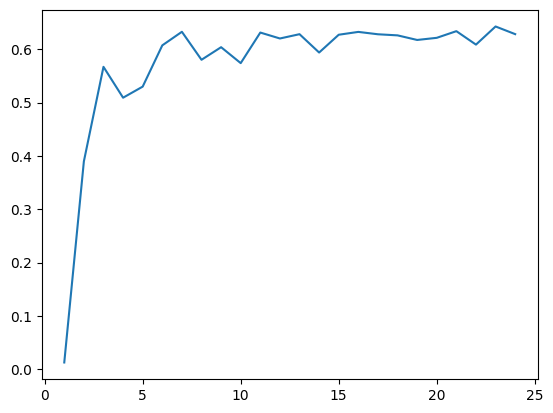

In [ ]:
# Метрика F1-Score
plt.plot(df['epoch'], df['F1'], label='F1-score')

# Оценка на test датасете

In [ ]:
# Загрузка обученной модели
model = YOLO('/content/drive/MyDrive/Zebra/Results/exp1/weights/best.pt')

# Оценка на тестовой выборке
metrics = model.val(data=data_yaml_path, split='test')


Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 0.1±0.0 MB/s, size: 73.2 KB)


val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/test/labels.cache... 40 images, 24 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:33<00:00, 11.27s/it]


                   all         40         88       0.56      0.781      0.661      0.525
                  fork          6         12       0.69        0.5      0.586      0.443
                 salad         13         26      0.525      0.885      0.712      0.642
         second_course         12         12      0.422          1      0.751      0.674
                  soup         12         18      0.567      0.722      0.606      0.517
                 spoon         16         20      0.594        0.8      0.649      0.351
Speed: 2.4ms preprocess, 5.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val


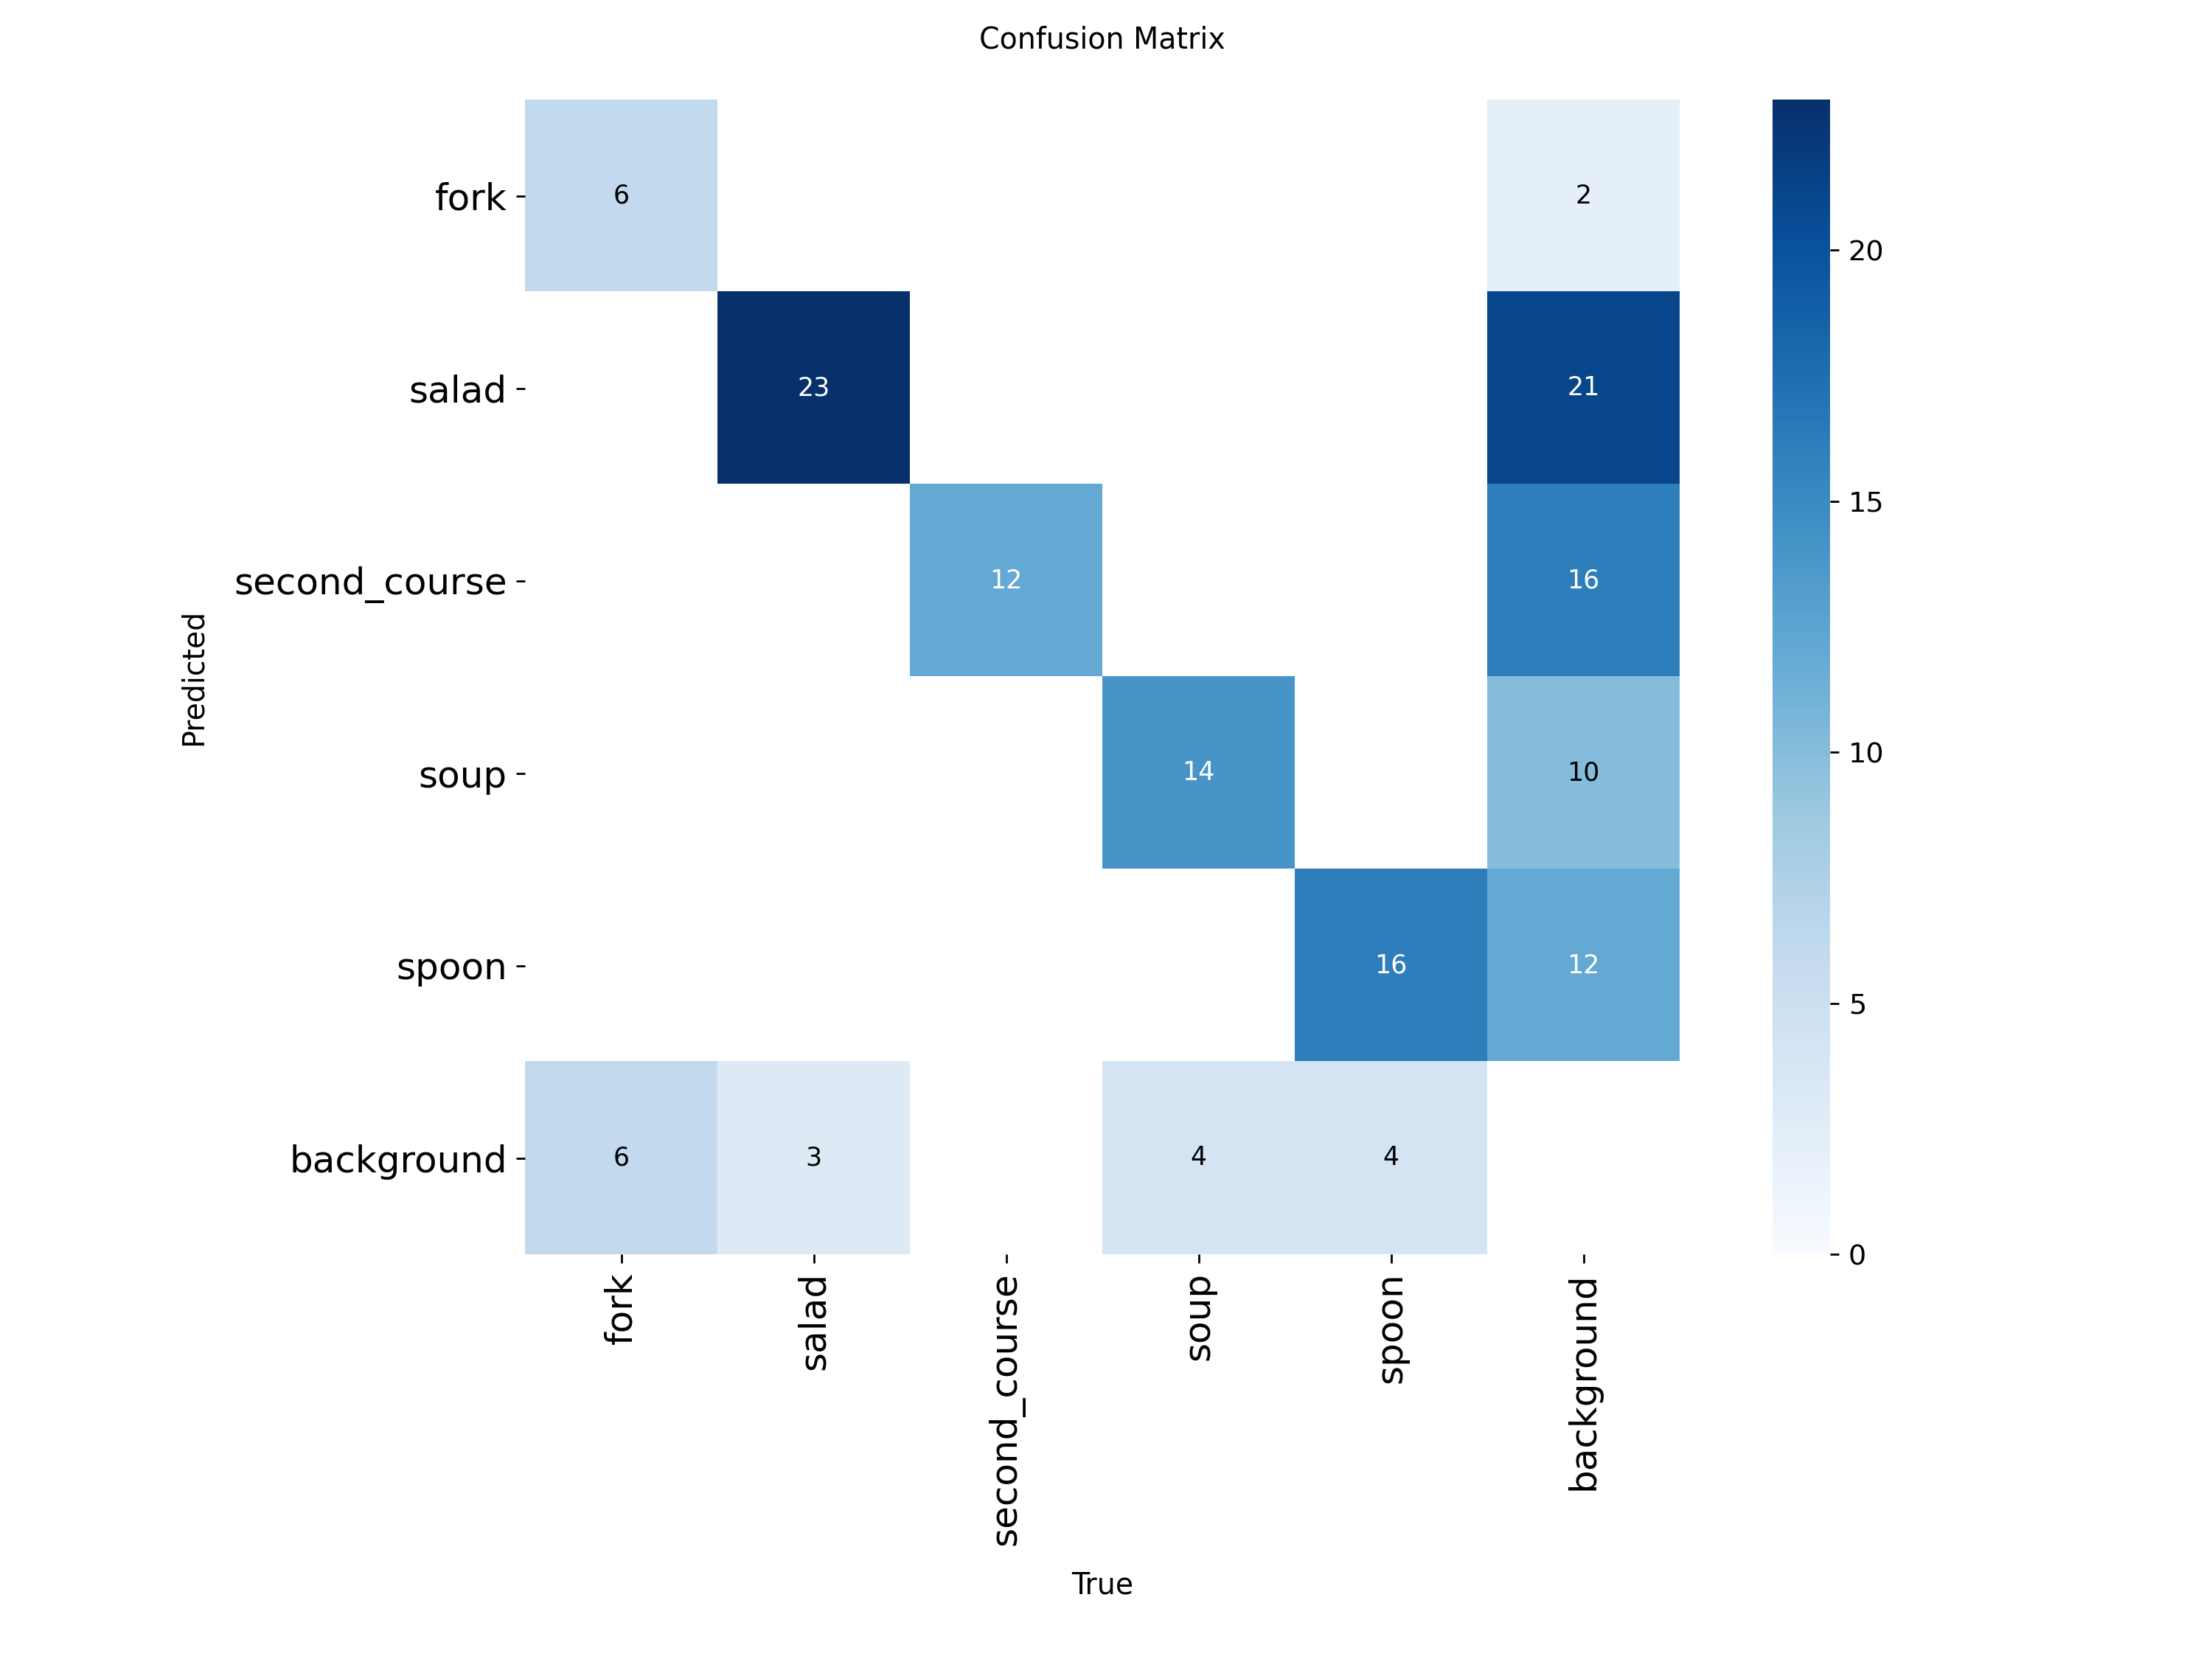

In [ ]:
# Метрики test
from IPython.display import Image

# Путь к файлу (может отличаться в зависимости от версии YOLO)
conf_matrix_path = '/content/runs/detect/val/confusion_matrix.png'

# Отображение в Colab
Image(conf_matrix_path)

In [ ]:
# Загрузка метрик test выборки

from IPython.display import Image, display
import matplotlib.pyplot as plt

# Пути к файлам
f1_path = '/content/runs/detect/val/F1_curve.png'
cm_path = '/content/runs/detect/val/confusion_matrix.png'
pr_path = '/content/runs/detect/val/PR_curve.png'

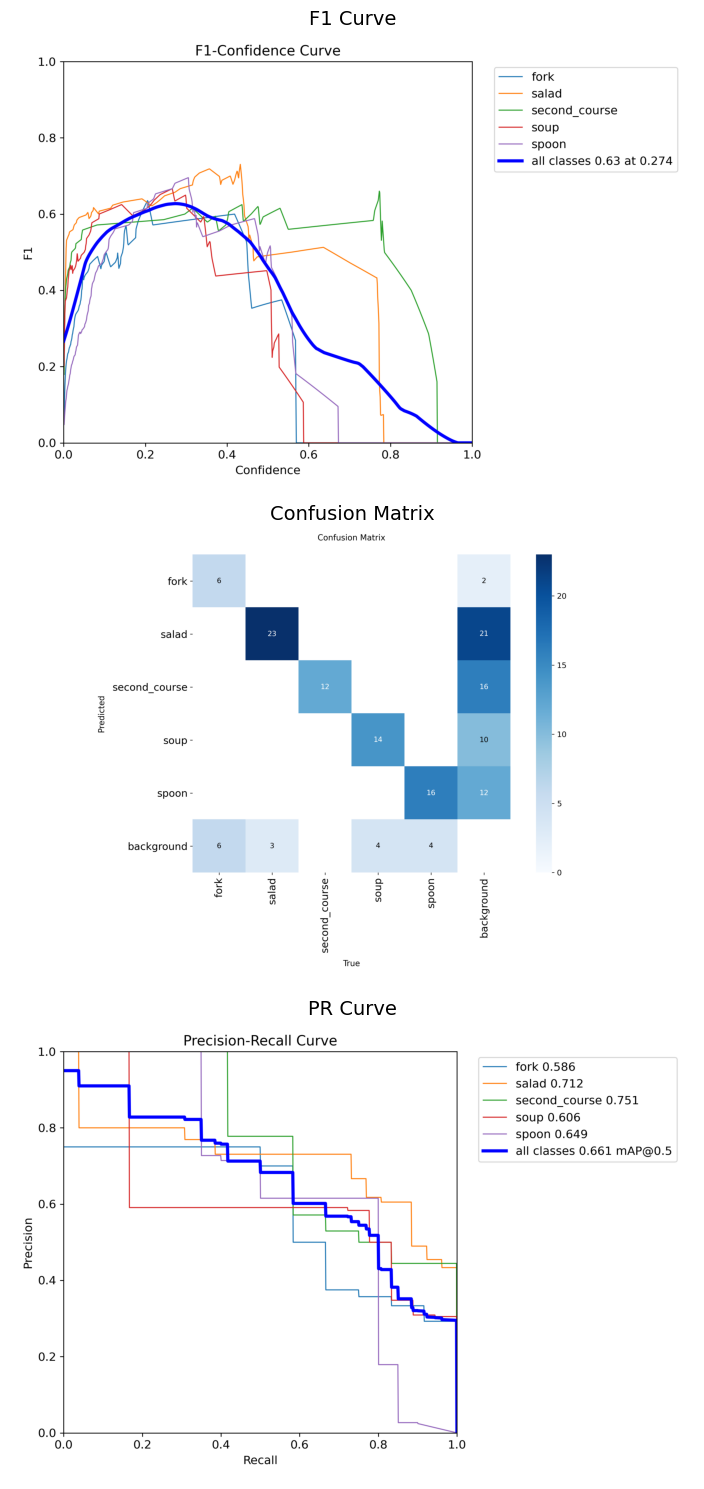

In [ ]:
# Загрузка Confusion Matrix (если она сохранена YOLO)

# Создаем фигуру с 3 субплoтами
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

# Настраиваем расстояние между графиками
plt.subplots_adjust(wspace=0.3)

# Загружаем и отображаем каждый график
axes[0].imshow(plt.imread(f1_path))
axes[0].axis('off')
axes[0].set_title('F1 Curve', fontsize=14)

axes[1].imshow(plt.imread(cm_path))
axes[1].axis('off')
axes[1].set_title('Confusion Matrix', fontsize=14)

axes[2].imshow(plt.imread(pr_path))
axes[2].axis('off')
axes[2].set_title('PR Curve', fontsize=14)

plt.tight_layout()
plt.show()

# Запуск YOLO11n

In [ ]:
# Папка для сохранения результатов
project_dir = '/content/drive/MyDrive/Zebra/Results'

    data_yaml = data_yaml_path,
    model_name = 'yolo11n.pt',
    epochs = 40,
    batch = 16,
    imgsz = 640,
    lr0 = 0.01,
    weight_decay = 0.0005,
    project = project_dir,
    name = 'exp2',
    # Дополнительные параметры аугментации и настройки обучения:
    label_smoothing = 0.2,
    optimizer = 'AdamW',    
    mosaic = 0.1,
    mixup = 0.4,
    iou = 0.3,
    patience = 6

In [ ]:
trainer = YOLO_Trainer(
    data_yaml = data_yaml_path,
    model_name = 'yolo11n.pt',
    epochs = 40,
    batch = 16,
    imgsz = 640,
    lr0 = 0.01,
    weight_decay = 0.0005,
    project = project_dir,
    name = 'exp2',
    # Дополнительные параметры аугментации и настройки обучения:
    label_smoothing = 0.2,
    optimizer = 'AdamW',
    mosaic = 0.1,
    mixup = 0.4,
    iou = 0.3,
    patience = 6
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 111MB/s]


In [ ]:
trainer.setup_model()
trainer.train()

metrics = trainer.evaluate()

[INFO] Model yolo11n.pt loaded.
[INFO] Starting training for 40 epochs, batch size 16, img size 640...
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.3, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.4, mode=train, 

100%|██████████| 755k/755k [00:00<00:00, 23.1MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,815 parameters, 2,590,799 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 0.2±0.0 MB/s, size: 70.1 KB)


train: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/train/labels.cache... 822 images, 471 backgrounds, 0 corrupt: 100%|██████████| 822/822 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 0.2±0.1 MB/s, size: 73.9 KB)


val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/valid/labels.cache... 78 images, 43 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Zebra/Results/exp2/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Zebra/Results/exp2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       2.2G      1.806      3.195      1.719         19        640: 100%|██████████| 52/52 [00:51<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         78        212          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40       2.6G      1.697      2.327      1.601          9        640: 100%|██████████| 52/52 [00:20<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/3 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.21s/it]

                   all         78        212   0.000136     0.0246   9.71e-05   2.25e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.61G      1.608      2.145      1.523         31        640: 100%|██████████| 52/52 [00:24<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         78        212      0.689      0.171      0.174     0.0828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.61G      1.511      2.011      1.484         16        640: 100%|██████████| 52/52 [00:26<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         78        212      0.376       0.28      0.157     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.62G      1.423      1.928      1.414         46        640: 100%|██████████| 52/52 [00:22<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         78        212       0.74      0.132      0.165      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.62G      1.366      1.789      1.362         21        640: 100%|██████████| 52/52 [00:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         78        212      0.145      0.643      0.285      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.62G      1.338      1.733      1.361         27        640: 100%|██████████| 52/52 [00:21<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         78        212      0.562       0.35      0.302        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.63G      1.268      1.652      1.298          5        640: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         78        212      0.452      0.764      0.544       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.64G      1.305      1.716      1.335         14        640: 100%|██████████| 52/52 [00:21<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         78        212      0.721      0.341      0.261      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.66G       1.26      1.629      1.309         22        640: 100%|██████████| 52/52 [00:19<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         78        212      0.554      0.579      0.544      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.67G      1.276      1.629      1.311         27        640: 100%|██████████| 52/52 [00:19<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         78        212      0.424      0.709       0.51      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.68G      1.205      1.567      1.278         25        640: 100%|██████████| 52/52 [00:20<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         78        212      0.597      0.533      0.541      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.68G      1.153      1.532      1.242         27        640: 100%|██████████| 52/52 [00:19<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         78        212      0.545      0.692      0.553      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.68G      1.165      1.521      1.256         25        640: 100%|██████████| 52/52 [00:22<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         78        212      0.452       0.76      0.532       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.68G      1.099      1.416      1.219         22        640: 100%|██████████| 52/52 [00:19<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         78        212      0.478      0.777      0.559      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.68G      1.102      1.484      1.196         34        640: 100%|██████████| 52/52 [00:20<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         78        212      0.597       0.61      0.567      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.68G      1.062      1.432      1.198         18        640: 100%|██████████| 52/52 [00:20<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         78        212      0.525      0.644      0.574      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.68G      1.074      1.435      1.178         28        640: 100%|██████████| 52/52 [00:19<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         78        212      0.505      0.751      0.556      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.68G      1.024      1.356      1.175         18        640: 100%|██████████| 52/52 [00:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         78        212      0.448      0.763      0.533      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.68G      1.053      1.398      1.184         12        640: 100%|██████████| 52/52 [00:19<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         78        212      0.543      0.672      0.604       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.68G      1.023      1.357      1.166         15        640: 100%|██████████| 52/52 [00:21<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         78        212      0.473      0.772      0.565      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.69G      1.032      1.365      1.154         22        640: 100%|██████████| 52/52 [00:19<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         78        212      0.538      0.708      0.614      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.69G       1.02      1.333      1.164         10        640: 100%|██████████| 52/52 [00:20<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         78        212      0.591      0.675      0.565       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.69G     0.9778      1.278      1.134         26        640: 100%|██████████| 52/52 [00:20<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         78        212       0.53      0.734      0.555      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.69G      1.008      1.357      1.162         25        640: 100%|██████████| 52/52 [00:19<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         78        212      0.483      0.792      0.571      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      2.69G      0.933      1.257      1.113         38        640: 100%|██████████| 52/52 [00:21<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         78        212      0.559      0.697      0.628      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.69G      0.943      1.256      1.107         15        640: 100%|██████████| 52/52 [00:19<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         78        212      0.572      0.688      0.589      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.69G     0.9348       1.29      1.111         10        640: 100%|██████████| 52/52 [00:20<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         78        212       0.55      0.675      0.573      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.69G     0.9197      1.237        1.1         14        640: 100%|██████████| 52/52 [00:19<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         78        212      0.594      0.599      0.577      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.69G     0.8999      1.208      1.088         38        640: 100%|██████████| 52/52 [00:20<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         78        212      0.585      0.675      0.602      0.448


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.69G     0.7437        1.1     0.9957          5        640: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


                   all         78        212      0.504      0.755        0.6       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.69G     0.7327      1.103     0.9901         10        640: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all         78        212      0.554      0.704      0.637      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.69G     0.7003      1.048     0.9798         30        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         78        212      0.584      0.666      0.628      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.69G     0.6817       1.04     0.9783         14        640: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         78        212      0.591      0.623      0.617      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.69G      0.678      1.017     0.9653         16        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         78        212      0.577      0.665      0.642      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.69G     0.6674     0.9925     0.9708         11        640: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         78        212      0.579      0.663      0.638      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.69G     0.6544     0.9808       0.97         23        640: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         78        212      0.618      0.599      0.633      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.69G     0.6352     0.9762     0.9499         20        640: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         78        212      0.576       0.67      0.644      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.69G     0.6375     0.9643     0.9602          7        640: 100%|██████████| 52/52 [00:16<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         78        212      0.575      0.683      0.635      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.69G     0.6081      1.012     0.9431          9        640: 100%|██████████| 52/52 [00:16<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         78        212      0.574      0.673      0.658      0.535



40 epochs completed in 0.251 hours.
Optimizer stripped from /content/drive/MyDrive/Zebra/Results/exp2/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Zebra/Results/exp2/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Zebra/Results/exp2/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


                   all         78        212      0.574      0.673      0.657      0.533
                  fork         14         28      0.458        0.5      0.425      0.325
                 salad         33         65      0.631      0.785      0.794      0.725
         second_course         33         33      0.639      0.752      0.784      0.726
                  soup         28         42      0.502       0.69      0.633      0.545
                 spoon         33         44      0.638      0.636      0.651      0.344
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/Zebra/Results/exp2
[INFO] Training finished. Results saved in '/content/drive/MyDrive/Zebra/Results/exp2'
[INFO] Evaluating on test set...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2

val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/test/labels.cache... 40 images, 24 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


                   all         40         88      0.626      0.699      0.676      0.543
                  fork          6         12        0.7        0.5      0.584      0.507
                 salad         13         26       0.61      0.769      0.717      0.645
         second_course         12         12      0.587      0.833      0.735      0.663
                  soup         12         18      0.576      0.722      0.674       0.56
                 spoon         16         20      0.657       0.67       0.67      0.341
Speed: 0.3ms preprocess, 6.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/drive/MyDrive/Zebra/Results/exp22
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1c1374c310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Conf

In [ ]:
# Проверка названий колонок
df = pd.read_csv(project_dir + '/exp2/results.csv')
print(df.columns.tolist())

['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


In [ ]:
trainer.plot_metrics_interactive()

In [ ]:
# Score
df['F1'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'] + 1e-16)

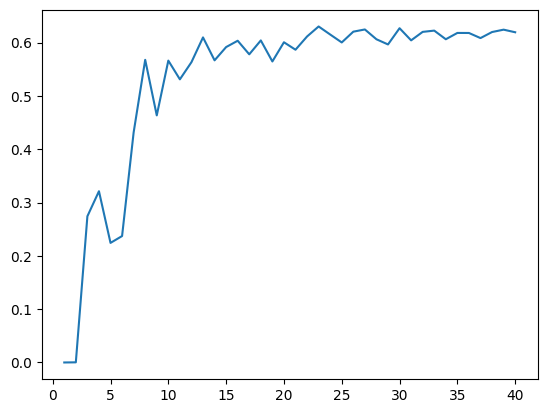

In [ ]:
plt.plot(df['epoch'], df['F1'], label='F1-score')

# Оценка на test датасете  

In [ ]:
# Загрузка обученной модели
model = YOLO('/content/drive/MyDrive/Zebra/Results/exp2/weights/best.pt')

# Оценка на тестовой выборке
metrics = model.val(data=data_yaml_path, split='test')

Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 43.4±11.1 MB/s, size: 73.2 KB)


val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/test/labels.cache... 40 images, 24 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


                   all         40         88      0.631      0.695      0.677      0.543
                  fork          6         12      0.702        0.5      0.595      0.512
                 salad         13         26      0.612      0.769      0.717      0.645
         second_course         12         12      0.596      0.833      0.735      0.663
                  soup         12         18      0.605      0.722      0.673      0.558
                 spoon         16         20      0.637       0.65      0.663      0.339
Speed: 5.4ms preprocess, 14.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val


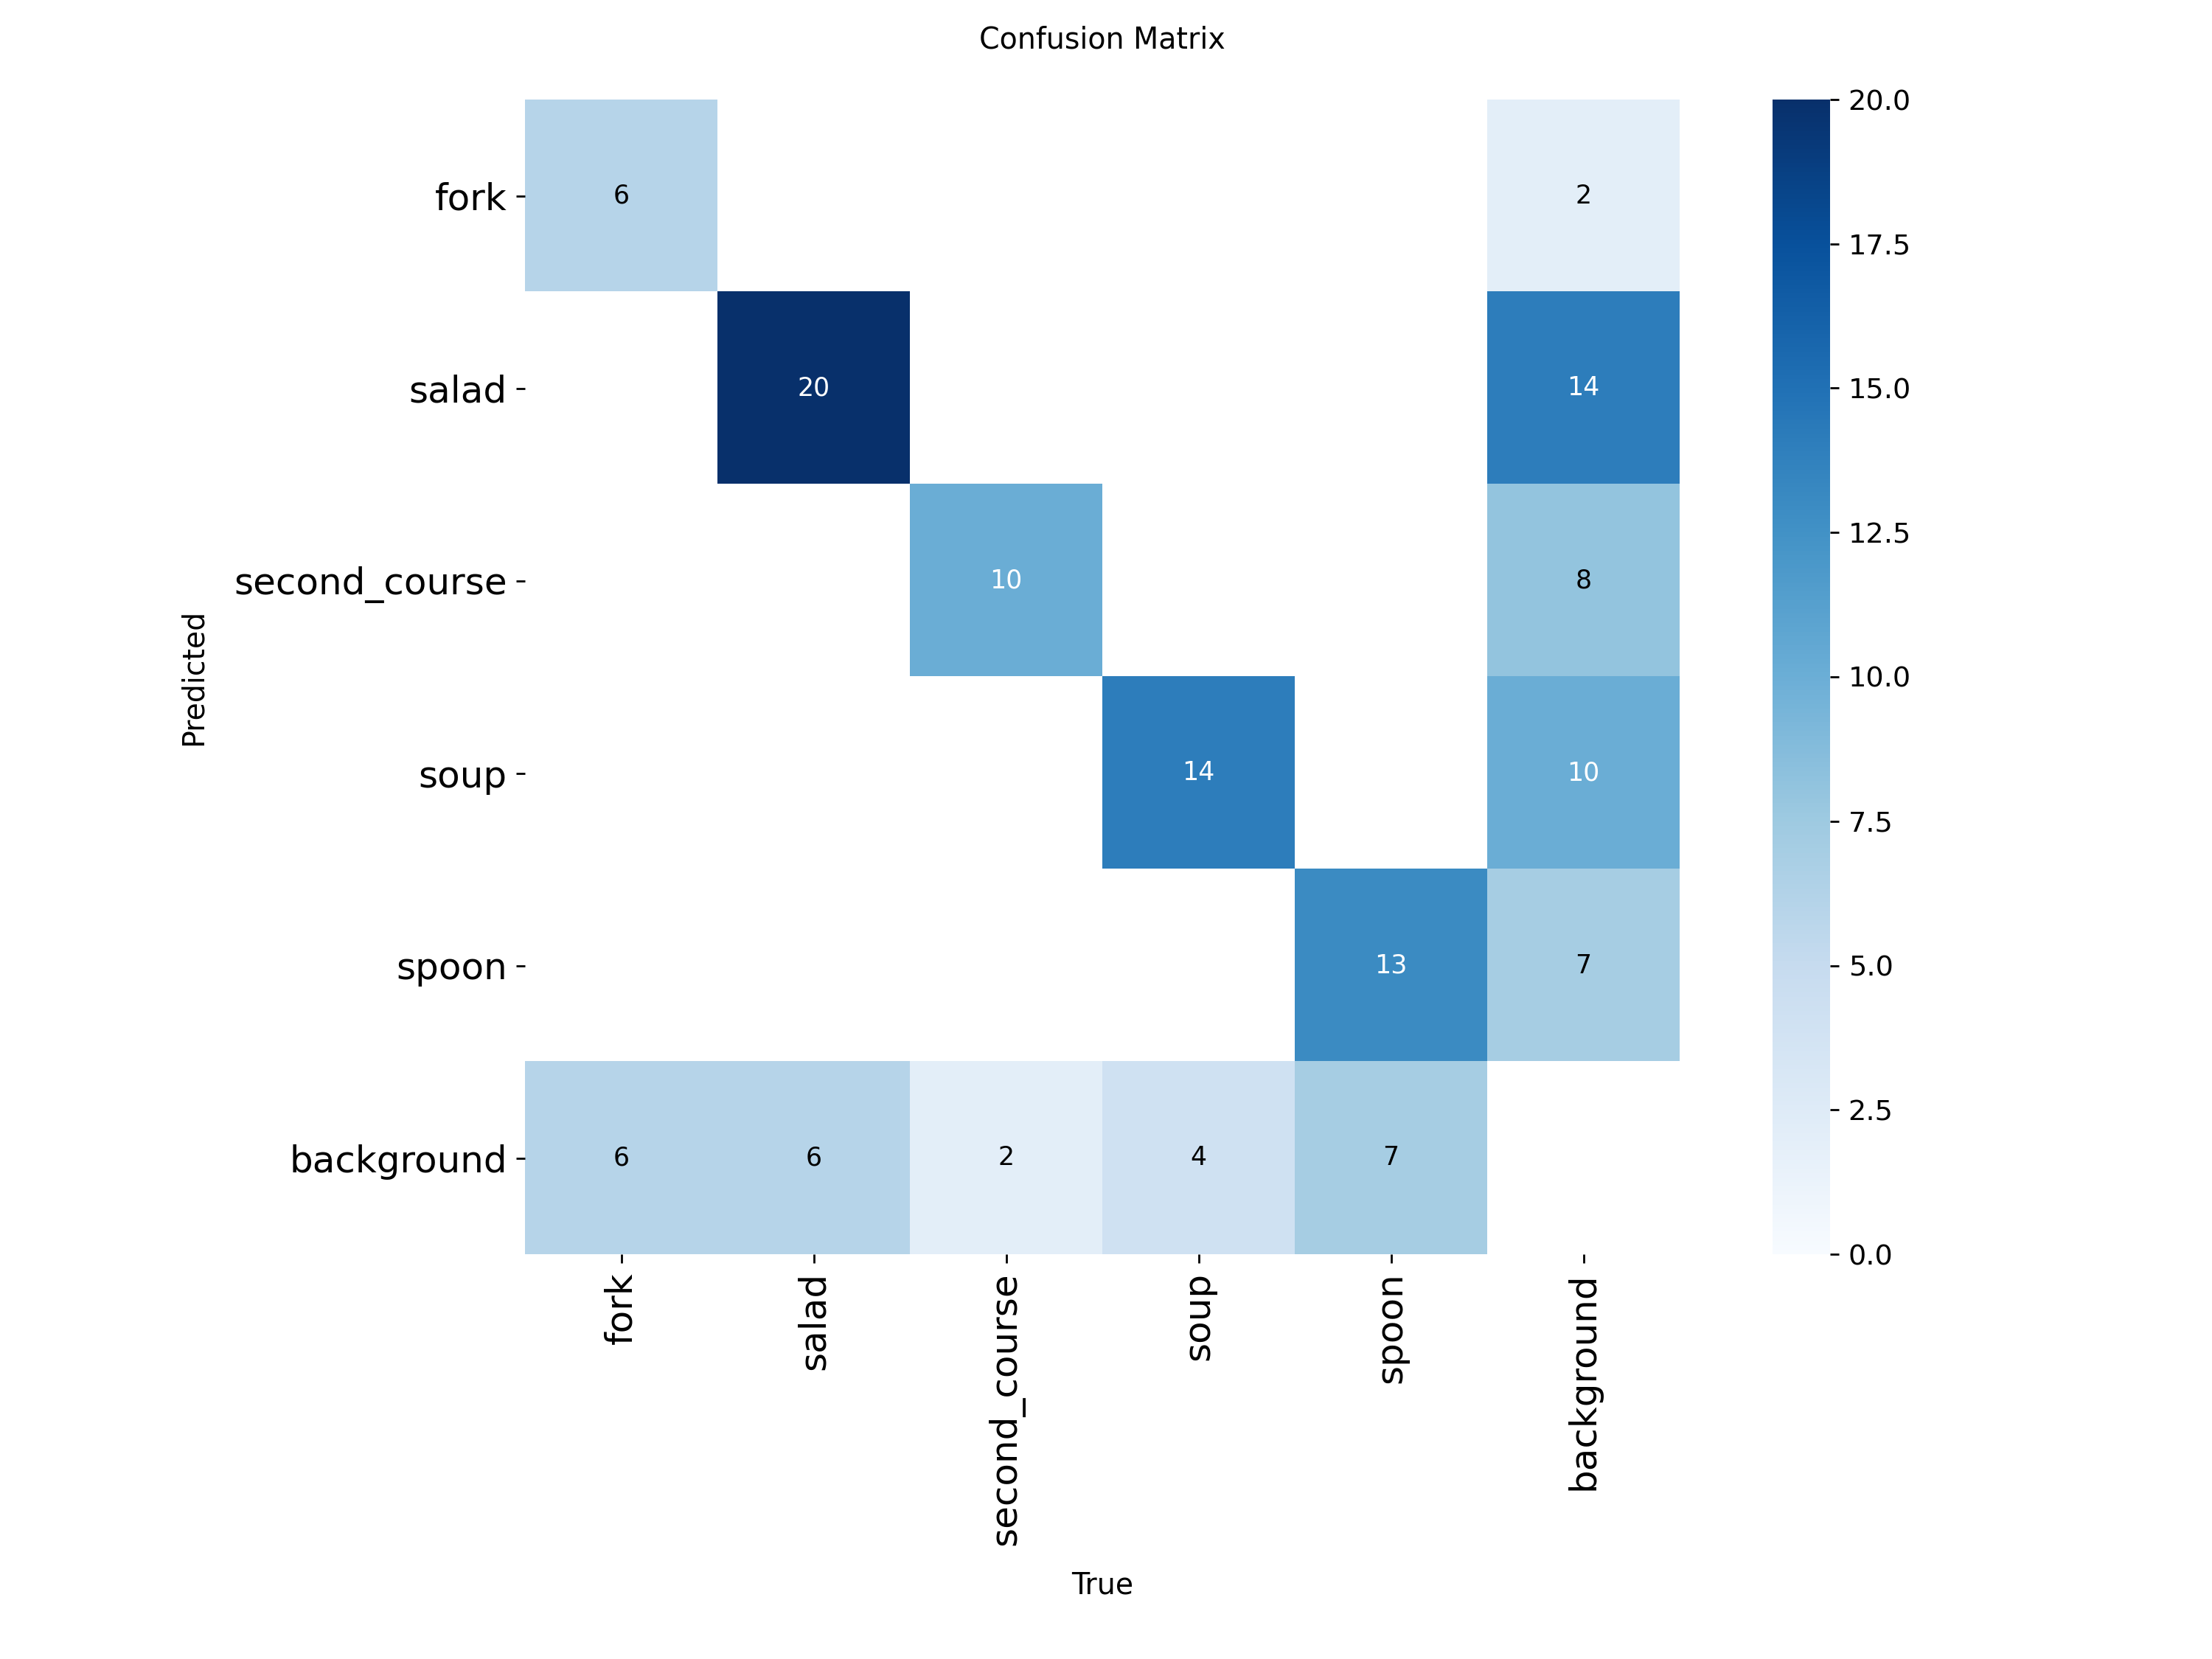

In [ ]:
# Метрики test
from IPython.display import Image

# Путь к файлу (может отличаться в зависимости от версии YOLO)
conf_matrix_path = '/content/runs/detect/val/confusion_matrix.png'

# Отображение в Colab
Image(conf_matrix_path)

# Тренировка YOLO11n с другими параметрами

    data_yaml = data_yaml_path,
    model_name = 'yolo11n.pt',
    epochs = 60,
    batch = 16,
    imgsz = 1280,
    lr0 = 0.01,
    weight_decay = 0.0005,
    project = project_dir,
    name = 'exp3',
    # Дополнительные параметры аугментации и настройки обучения:
    label_smoothing = 0.25,
    optimizer = 'AdamW',    
    mosaic = 0.1,
    mixup = 0.4,
    iou = 0.3,
    patience = 6

In [12]:
trainer = YOLO_Trainer(
    data_yaml = data_yaml_path,
    model_name = 'yolo11n.pt',
    epochs = 60,
    batch = 16,
    imgsz = 1280,
    lr0 = 0.01,
    weight_decay = 0.0005,
    project = project_dir,
    name = 'exp3',
    # Дополнительные параметры аугментации и настройки обучения:
    label_smoothing = 0.25,
    optimizer = 'AdamW',
    mosaic = 0.1,
    mixup = 0.4,
    iou = 0.3,
    patience = 6
)


100%|██████████| 5.35M/5.35M [00:00<00:00, 91.4MB/s]


In [13]:
trainer.setup_model()
trainer.train()
metrics = trainer.evaluate()

[INFO] Model yolo11n.pt loaded.
[INFO] Starting training for 60 epochs, batch size 16, img size 1280...
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.3, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.4, mode=train

100%|██████████| 755k/755k [00:00<00:00, 27.0MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,815 parameters, 2,590,799 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.2±0.0 MB/s, size: 70.1 KB)


train: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/train/labels.cache... 822 images, 471 backgrounds, 0 corrupt: 100%|██████████| 822/822 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 1.5±1.8 ms, read: 0.1±0.1 MB/s, size: 73.9 KB)


val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/valid/labels.cache... 78 images, 43 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Zebra/Results/exp3/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Zebra/Results/exp3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      9.59G      1.922      3.807      2.016         19       1280: 100%|██████████| 52/52 [01:15<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.01s/it]

                   all         78        212    0.00357      0.152    0.00326   0.000768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      8.93G      1.833      2.708      1.915          9       1280: 100%|██████████| 52/52 [01:34<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]

                   all         78        212   0.000147     0.0429   9.02e-05   1.93e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      8.92G      1.748      2.441      1.822         31       1280: 100%|██████████| 52/52 [01:27<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]

                   all         78        212       0.44      0.164     0.0769     0.0368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      8.93G      1.618      2.265      1.733         16       1280: 100%|██████████| 52/52 [01:21<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all         78        212      0.783      0.185      0.196     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60         9G      1.555       2.19      1.695         46       1280: 100%|██████████| 52/52 [01:18<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         78        212      0.357       0.27      0.149      0.064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      8.97G       1.47      1.967      1.591         21       1280: 100%|██████████| 52/52 [01:11<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

                   all         78        212      0.329      0.264      0.142     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      8.92G      1.424      1.954      1.571         27       1280: 100%|██████████| 52/52 [01:12<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         78        212      0.269       0.67      0.319      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      8.88G      1.363      1.843      1.504          5       1280: 100%|██████████| 52/52 [01:10<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all         78        212      0.367      0.694       0.47      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      8.97G      1.404      1.921      1.551         14       1280: 100%|██████████| 52/52 [01:11<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         78        212      0.446      0.649      0.429      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      8.94G      1.335      1.813      1.517         22       1280: 100%|██████████| 52/52 [01:11<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         78        212      0.428      0.769      0.539      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      9.06G      1.304      1.754      1.482         27       1280: 100%|██████████| 52/52 [01:08<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all         78        212      0.525      0.657      0.529      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      8.88G       1.28      1.732      1.475         25       1280: 100%|██████████| 52/52 [01:19<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         78        212      0.322      0.582      0.466      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      8.97G      1.235      1.673      1.432         27       1280: 100%|██████████| 52/52 [01:18<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         78        212      0.427      0.727      0.533      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      8.98G      1.227      1.661      1.424         25       1280: 100%|██████████| 52/52 [01:15<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]

                   all         78        212      0.481      0.693      0.549      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      8.98G      1.139      1.557      1.377         22       1280: 100%|██████████| 52/52 [01:30<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.50s/it]

                   all         78        212      0.484      0.667      0.506      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      8.94G      1.169      1.595       1.36         34       1280: 100%|██████████| 52/52 [01:22<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all         78        212      0.442      0.779      0.565      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      8.85G      1.181      1.579      1.393         18       1280: 100%|██████████| 52/52 [01:16<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]

                   all         78        212      0.338      0.718      0.526       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      8.97G      1.182      1.637      1.386         28       1280: 100%|██████████| 52/52 [01:26<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         78        212      0.615      0.559      0.481       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      8.87G      1.142      1.528      1.357         18       1280: 100%|██████████| 52/52 [01:18<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         78        212       0.47      0.714      0.559      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      8.92G      1.103      1.518      1.348         12       1280: 100%|██████████| 52/52 [01:44<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]

                   all         78        212      0.653      0.448      0.494      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      8.88G      1.121      1.533      1.356         15       1280: 100%|██████████| 52/52 [01:28<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all         78        212      0.538      0.696      0.611      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      8.97G      1.108      1.486      1.311         22       1280: 100%|██████████| 52/52 [01:12<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         78        212      0.401      0.737      0.577      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      8.92G      1.131      1.474      1.349         10       1280: 100%|██████████| 52/52 [01:21<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         78        212      0.475      0.798      0.576      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      8.98G      1.046      1.368      1.284         26       1280: 100%|██████████| 52/52 [01:15<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         78        212      0.576      0.715      0.606      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      8.87G      1.074      1.471       1.31         25       1280: 100%|██████████| 52/52 [01:23<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]

                   all         78        212      0.403      0.654      0.514      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      8.93G      1.037      1.425      1.294         38       1280: 100%|██████████| 52/52 [01:18<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         78        212      0.548      0.711      0.589      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      8.92G      1.047      1.371       1.27         15       1280: 100%|██████████| 52/52 [01:17<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         78        212      0.536      0.726      0.585      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      8.98G      1.005      1.392      1.253         10       1280: 100%|██████████| 52/52 [01:18<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         78        212      0.528      0.712      0.628      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      8.92G      1.004       1.35      1.258         14       1280: 100%|██████████| 52/52 [01:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]

                   all         78        212      0.488      0.794      0.619      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      9.05G     0.9896      1.314      1.253         38       1280: 100%|██████████| 52/52 [01:20<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

                   all         78        212      0.599      0.659      0.586      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      8.92G     0.9887      1.298      1.233         24       1280: 100%|██████████| 52/52 [01:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         78        212      0.524      0.704      0.659      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      8.92G     0.9828       1.34      1.253          4       1280: 100%|██████████| 52/52 [02:58<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all         78        212      0.462       0.83      0.635      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      8.98G     0.9484      1.287      1.209         35       1280: 100%|██████████| 52/52 [01:58<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

                   all         78        212      0.546      0.737      0.627      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      8.92G     0.9497      1.244      1.207         43       1280: 100%|██████████| 52/52 [02:12<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

                   all         78        212       0.53      0.759      0.563      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      9.04G     0.9433      1.257      1.214         32       1280: 100%|██████████| 52/52 [02:02<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]

                   all         78        212      0.563      0.724      0.605      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      8.92G     0.9205      1.237      1.197         29       1280: 100%|██████████| 52/52 [01:45<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         78        212      0.533      0.713      0.638      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      8.96G     0.9263      1.218       1.19         31       1280: 100%|██████████| 52/52 [01:31<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all         78        212      0.529      0.674      0.602      0.464


EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

37 epochs completed in 0.969 hours.
Optimizer stripped from /content/drive/MyDrive/Zebra/Results/exp3/weights/last.pt, 5.6MB
Optimizer stripped from /content/drive/MyDrive/Zebra/Results/exp3/weights/best.pt, 5.6MB

Validating /content/drive/MyDrive/Zebra/Results/exp3/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


                   all         78        212      0.524      0.704       0.66      0.516
                  fork         14         28      0.398      0.355      0.412      0.278
                 salad         33         65       0.51      0.892      0.782      0.702
         second_course         33         33       0.65      0.788      0.794      0.741
                  soup         28         42       0.48       0.69      0.624      0.481
                 spoon         33         44      0.582      0.795      0.691      0.376
Speed: 1.0ms preprocess, 11.2ms inference, 0.0ms loss, 19.8ms postprocess per image
Results saved to /content/drive/MyDrive/Zebra/Results/exp3
[INFO] Training finished. Results saved in '/content/drive/MyDrive/Zebra/Results/exp3'
[INFO] Evaluating on val set...
Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.

val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/valid/labels.cache... 78 images, 43 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 2/5 [00:05<00:09,  3.06s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 3/5 [00:15<00:12,  6.35s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


                   all         78        212      0.523      0.681      0.585      0.463
                  fork         14         28      0.406       0.39      0.296      0.201
                 salad         33         65      0.541      0.815       0.72      0.647
         second_course         33         33      0.634      0.758      0.738      0.689
                  soup         28         42      0.478       0.69      0.532      0.422
                 spoon         33         44      0.558       0.75      0.641      0.355
Speed: 75.4ms preprocess, 90.5ms inference, 0.0ms loss, 99.5ms postprocess per image
Results saved to /content/drive/MyDrive/Zebra/Results/exp32


In [14]:
# Проверка названий колонок
df = pd.read_csv(project_dir + '/exp3/results.csv')
print(df.columns.tolist())

['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


In [15]:
trainer.plot_metrics_interactive()

In [16]:
# Score
df['F1'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / (df['metrics/precision(B)'] + df['metrics/recall(B)'] + 1e-16)

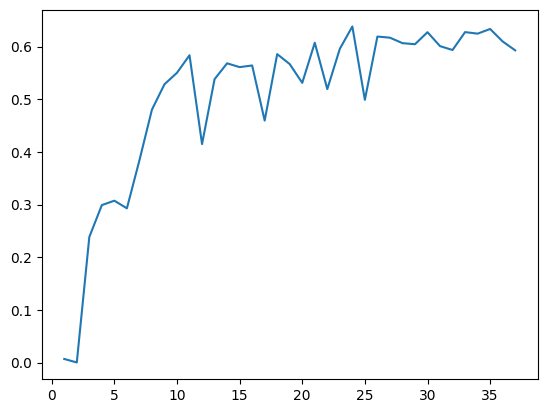

In [17]:
plt.plot(df['epoch'], df['F1'], label='F1-score')

# Оценка на test датасете

In [18]:

# Загрузка обученной модели
model = YOLO('/content/drive/MyDrive/Zebra/Results/exp3/weights/best.pt')

# Оценка на тестовой выборке
metrics = model.val(data=data_yaml_path, split='test')

Ultralytics 8.3.160 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.2±0.0 MB/s, size: 73.2 KB)


val: Scanning /content/drive/MyDrive/Zebra/My_First_Project.v4i.yolov11/test/labels.cache... 40 images, 24 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 2/3 [00:31<00:15, 15.02s/it]

WARNING ⚠️ NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [01:01<00:00, 20.51s/it]


                   all         40         88      0.648      0.396      0.446      0.326
                  fork          6         12          1          0      0.247      0.141
                 salad         13         26      0.543      0.549      0.578      0.513
         second_course         12         12      0.642      0.583       0.57      0.501
                  soup         12         18      0.508      0.346      0.321      0.236
                 spoon         16         20      0.545        0.5      0.516       0.24
Speed: 215.4ms preprocess, 289.0ms inference, 0.0ms loss, 142.0ms postprocess per image
Results saved to runs/detect/val


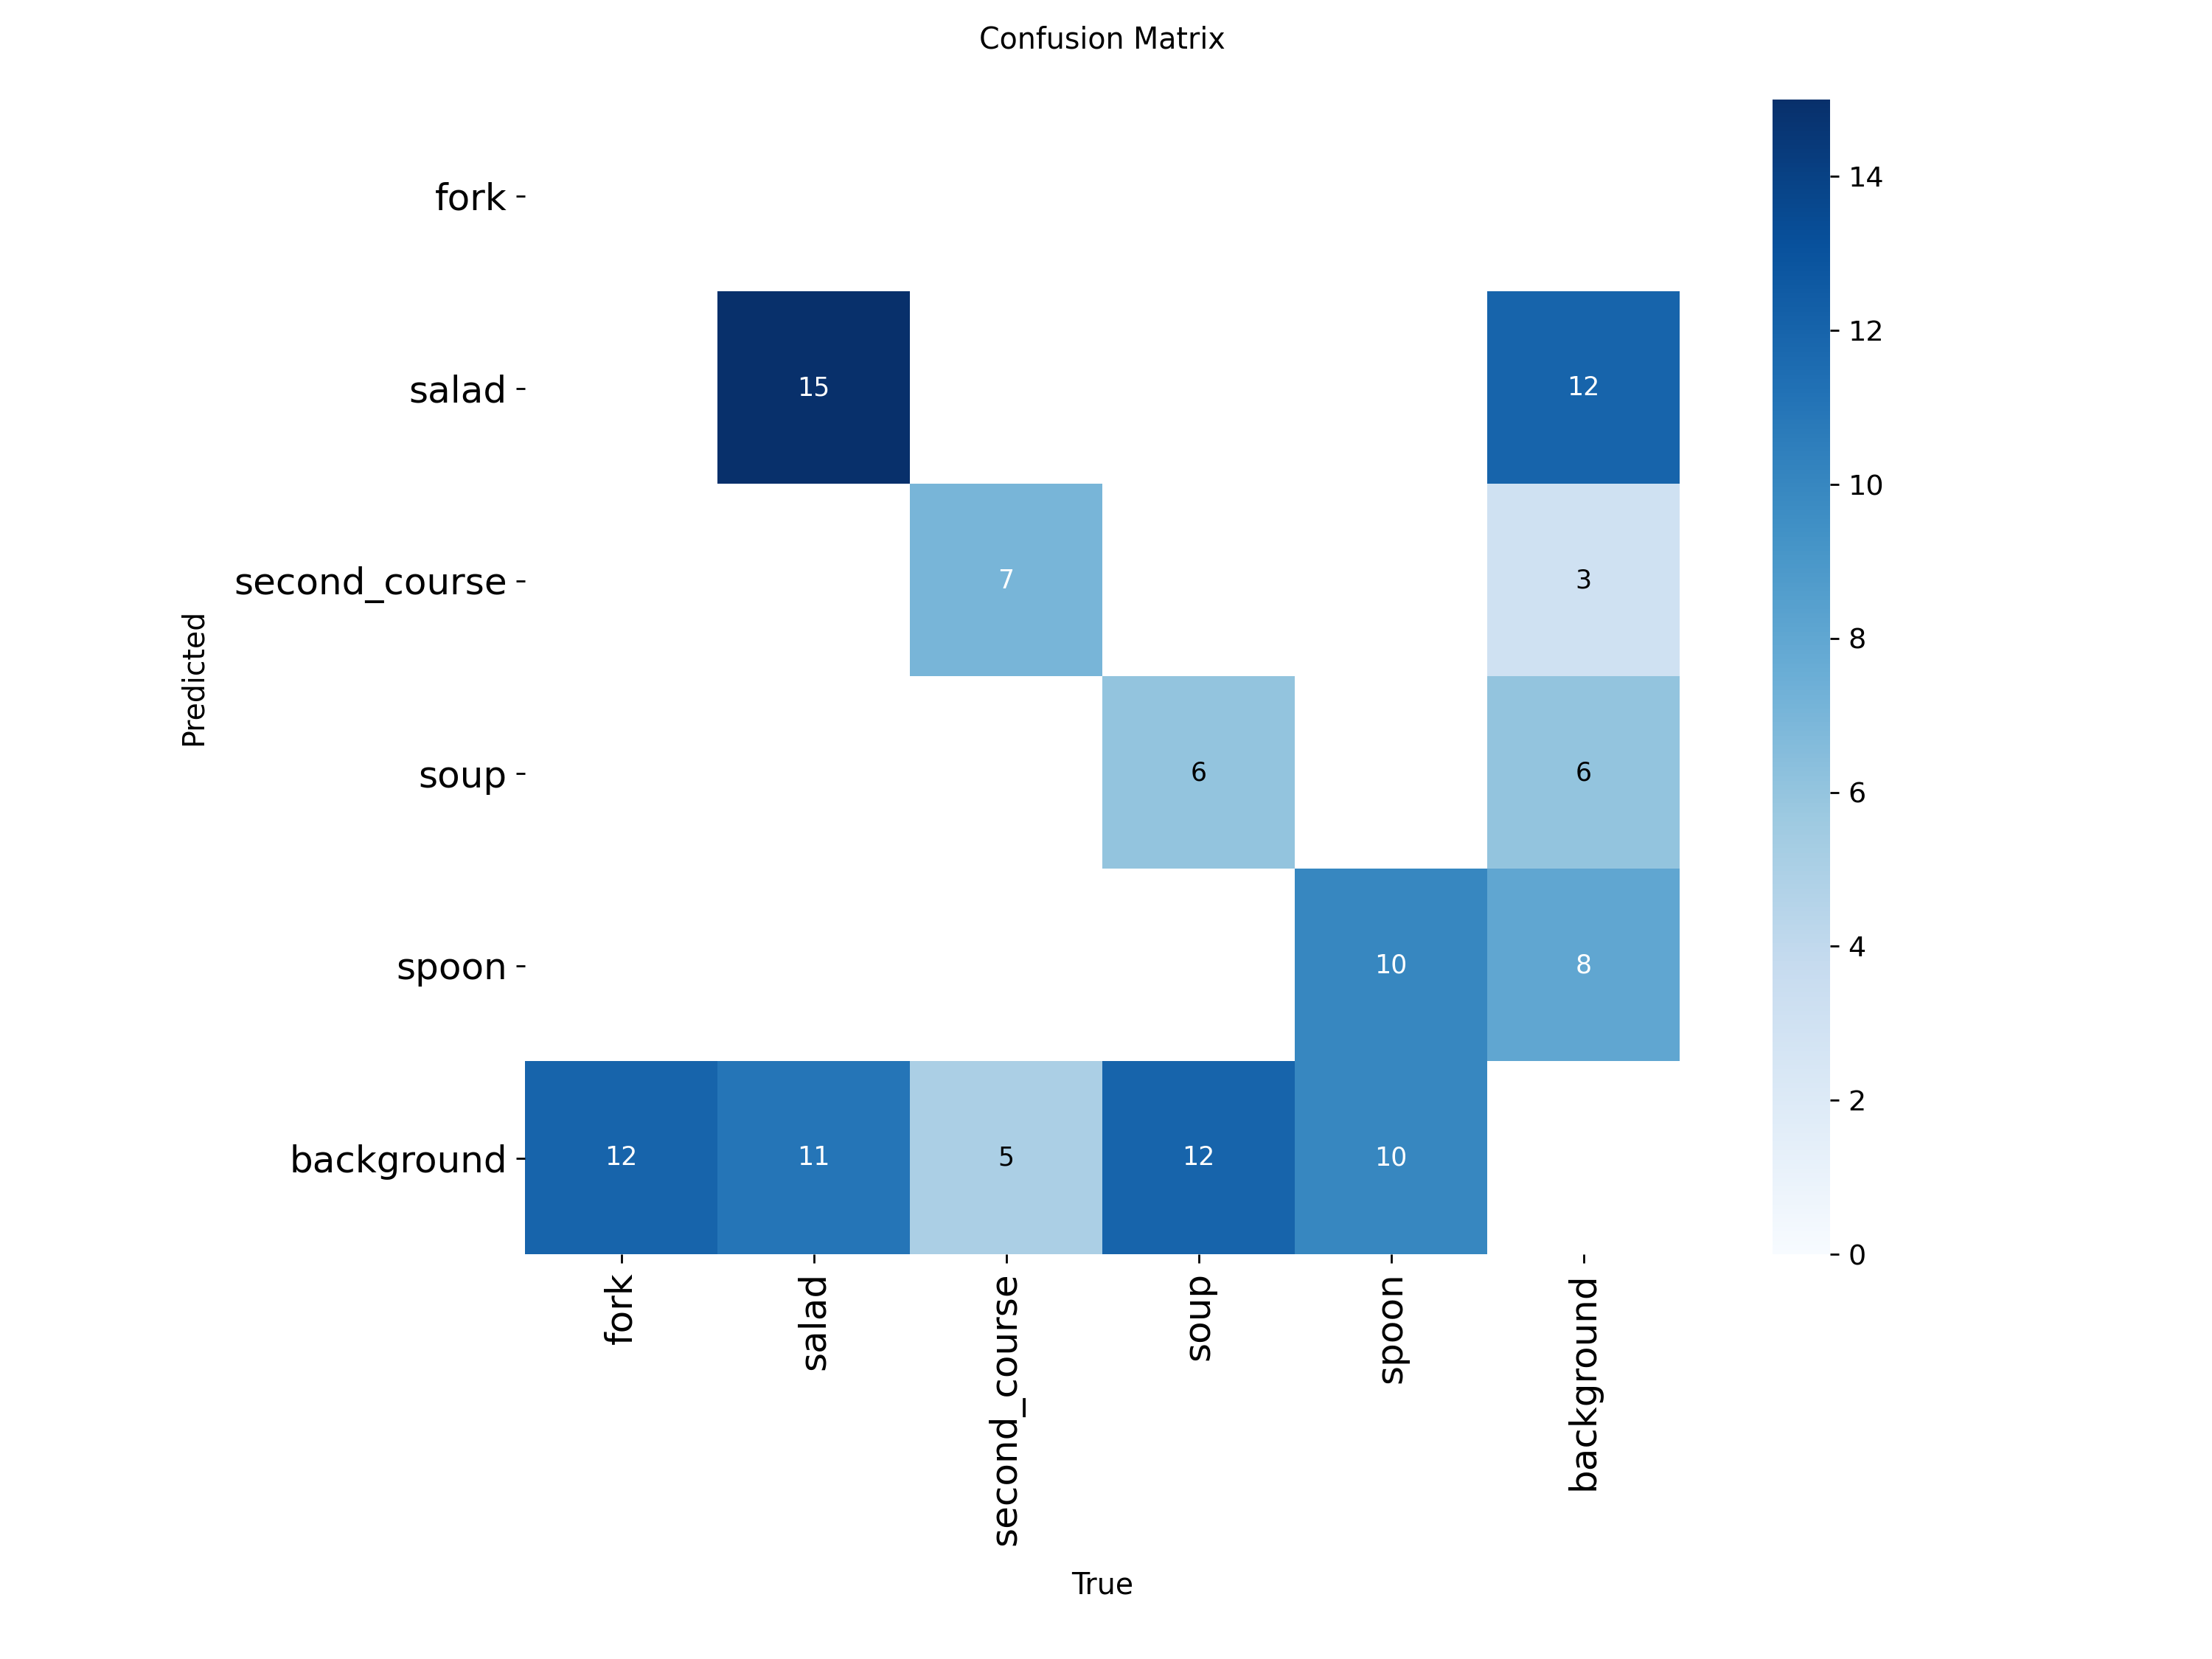

In [19]:
# Метрики test
from IPython.display import Image

# Путь к файлу (может отличаться в зависимости от версии YOLO)
conf_matrix_path = '/content/runs/detect/val/confusion_matrix.png'

# Отображение в Colab
Image(conf_matrix_path)

In [20]:
# Загрузка метрик test выборки

from IPython.display import Image, display
import matplotlib.pyplot as plt

# Пути к файлам
f1_path = '/content/runs/detect/val/F1_curve.png'
cm_path = '/content/runs/detect/val/confusion_matrix.png'
pr_path = '/content/runs/detect/val/PR_curve.png'

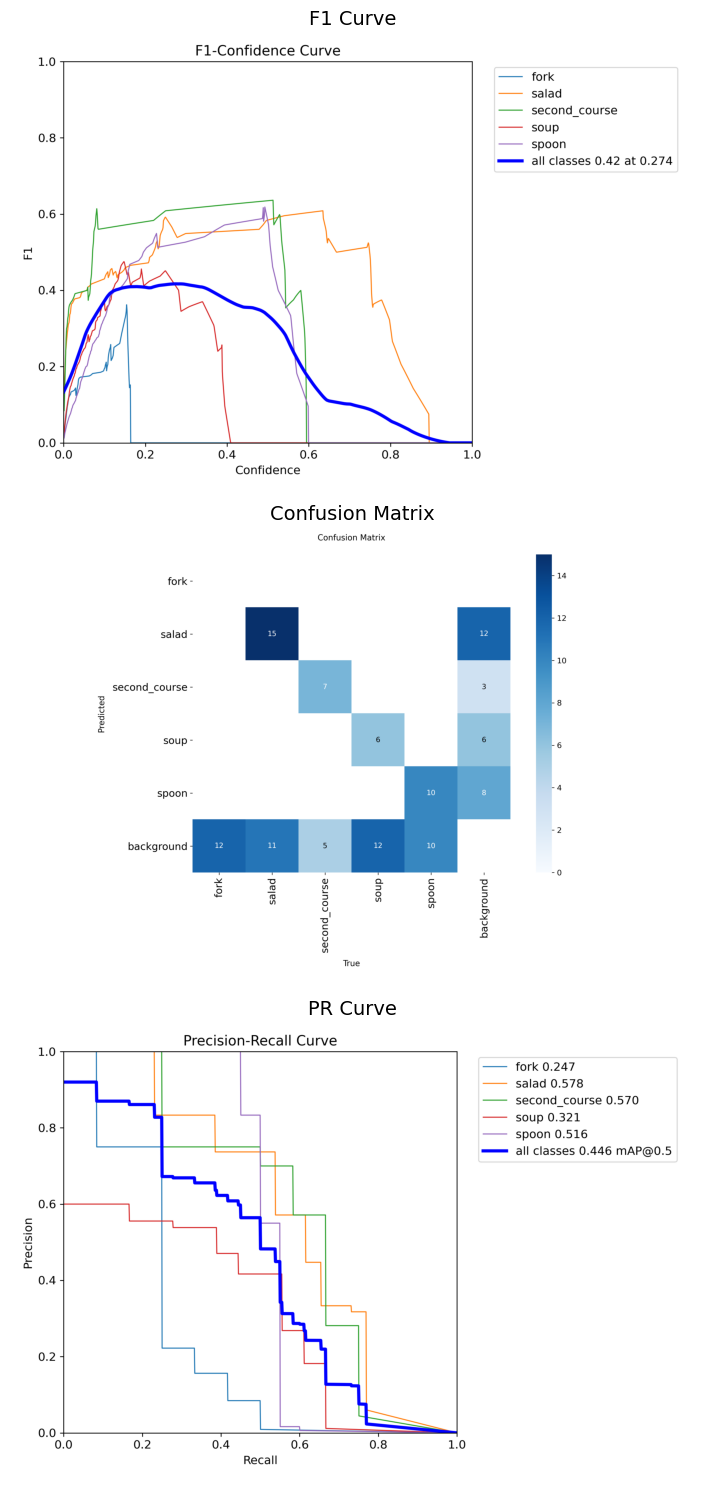

In [21]:
# Загрузка Confusion Matrix (если она сохранена YOLO)

# Создаем фигуру с 3 субплoтами
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

# Настраиваем расстояние между графиками
plt.subplots_adjust(wspace=0.3)

# Загружаем и отображаем каждый график
axes[0].imshow(plt.imread(f1_path))
axes[0].axis('off')
axes[0].set_title('F1 Curve', fontsize=14)

axes[1].imshow(plt.imread(cm_path))
axes[1].axis('off')
axes[1].set_title('Confusion Matrix', fontsize=14)

axes[2].imshow(plt.imread(pr_path))
axes[2].axis('off')
axes[2].set_title('PR Curve', fontsize=14)

plt.tight_layout()
plt.show()